In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd
import scipy.stats as spst

import argus_shapes
import pulse2percept.utils as p2pu

from sklearn.base import clone
import sklearn.metrics as sklm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-05-06 15:16:41,915 [pulse2percept] [INFO] Welcome to pulse2percept


# Load data

In [2]:
def load_data(pickle_files, verbose=True):
    data = []
    for pickle_file in pickle_files:
        if verbose:
            print('- Processing %s' % pickle_file)
        y, y_pred, best_params, specifics = pickle.load(open(pickle_file, 'rb'))
        if isinstance(specifics, list):
            assert np.allclose([s['avg_img'] for s in specifics], True)
            specifics = specifics[0]
        else:
            assert specifics['avg_img']
        if isinstance(y, list):
            y = pd.concat(y)
        if isinstance(y_pred, list):
            y_pred = pd.concat(y_pred)
            
        y['orientation'] = np.rad2deg(y['orientation'])
        y_pred['orientation'] = np.rad2deg(y_pred['orientation'])
        y['compactness'] = 1.0 / (y['compactness'] / (4 * np.pi))
        y_pred['compactness'] = 1.0 / (y_pred['compactness'] / (4 * np.pi))

            
        best_cost = 0
        r2_scores = {}
        for col in y_pred.drop(columns=['electrode', 'image']).columns:
#             yt = np.array(y.loc[:, col], dtype=float)
#             yp = np.array(y_pred.loc[:, col], dtype=float)
            yt = y.loc[:, col]
            yp = y_pred.loc[:, col]

            if col == 'orientation':
                # Use circular error:
                err = np.abs(yt - np.nan_to_num(yp))
                err = np.where(err > np.pi / 2, np.pi - err, err)
                # Use circular variance in `ss_tot`, which divides by len(yt).
                # Therefore, we also need to divide `ss_res` by len(yt), which
                # is the same as taking the mean instead of the sum.
                ss_res = np.mean(err ** 2)
                # ss_tot = np.sum((yt - np.mean(yt)) ** 2)
                ss_tot = spst.circvar(yt, low=-np.pi / 2, high=np.pi / 2)
                r2_scores['r2_orientation'] = 1 - ss_res / (ss_tot + 1e-12)
            else:
                r2_scores['r2_' + col] = sklm.r2_score(yt, np.nan_to_num(yp))
            
            l = 1 - r2_scores['r2_' + col]
            best_cost += 2 if np.isnan(l) else l
        row = {
            'subject': specifics['subject'],
            'model': specifics['modelname'],
            'exetime': specifics['exetime'],
            'adjust_bias': specifics['adjust_bias'],
            'best_cost': best_cost,
            'y_test': y,
            'y_pred': y_pred,
            'n_samples': len(yt),
            'filepath': os.path.dirname(pickle_file),
            'filename': os.path.basename(pickle_file)
        }
        row.update(best_params)
        row.update(r2_scores)
        data.append(row)
    return pd.DataFrame(data)

In [3]:
results_dir = '../../results/shape7fit/'
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
print('Found', len(pickle_files), 'files')

Found 4 files


In [4]:
subjects = ['TB', '12-005', '51-009', '52-001']
assert_params = {
    'amplitude': 2.0,
}
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')

In [5]:
data = load_data(pickle_files, verbose=False)
data

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/sklearn/metrics/regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


,adjust_bias,axlambda,best_cost,exetime,filename,filepath,model,n_samples,r2_area,r2_compactness,r2_eccentricity,r2_orientation,rho,subject,y_pred,y_test
0,False,1033.984229,4071.050036,2577.549673,12-005_C__shape7fit-swarm_2018-05-01_12-08-44....,../../results/shape7fit,C,18,-1.032208,-0.558354,-1.232586,-4064.226888,257.275430,12-005,area compactness eccentricity electrode ...,area compactness eccentricity electrode ...
1,False,1219.969482,inf,5209.390473,51-009_C__shape7fit-swarm_2018-05-01_12-08-51....,../../results/shape7fit,C,13,-4.577620,-inf,-61.991529,-4454.778094,110.546569,51-009,area compactness eccentricity electrode ...,area compactness eccentricity electrode ...
2,False,2947.595841,3595.565548,1231.331660,52-001_C__shape7fit-swarm_2018-05-01_12-08-57....,../../results/shape7fit,C,19,-0.372069,-0.710464,0.102516,-3590.585531,485.277498,52-001,area compactness eccentricity electrode...,area compactness eccentricity electrode...
3,False,2360.585051,411.407454,4858.812141,TB_C__shape7fit-swarm_2018-05-01_12-08-34.pickle,../../results/shape7fit,C,10,-1.029818,-0.364944,-0.416147,-405.596545,307.895445,TB,area compactness eccentricity electrode ...,area compactness eccentricity electrode ...


In [6]:
data.n_samples.unique()

array([18, 13, 19, 10])

# All runs

In [7]:
# Group by these:
groupcols = ['subject', 'model', 'adjust_bias']
# Don't show these:
extracols = ['filepath', 'exetime', 'n_samples', 'filename']
r2cols = ['r2_area', 'r2_orientation', 'r2_eccentricity', 'r2_compactness']

In [8]:
data.groupby(groupcols)['exetime', 'best_cost'].agg(['mean', 'std', 'count'])

exetime              best_cost          
                                  mean std count         mean std count
subject model adjust_bias                                              
12-005  C     False        2577.549673 NaN     1  4071.050036 NaN     1
51-009  C     False        5209.390473 NaN     1          inf NaN     1
52-001  C     False        1231.331660 NaN     1  3595.565548 NaN     1
TB      C     False        4858.812141 NaN     1   411.407454 NaN     1

# The best runs in their respective category

In [9]:
# 51-009
# Best err: 7.80698395097 Best params: {
#     'implant_x': -799.1442217201959, 
#     'loc_od_y': 0.7546936471295187, 
#     'rho': 50.0, 
#     'loc_od_x': 15.654335316168801, 
#     'implant_rot': -1.0921220639722116, 
#     'axlambda': 1103.7970402031128, 
#     'implant_y': 92.753210211560955}

In [10]:
print('Best scores:')
# Find the rows that have the best score in their subject/model/bias group:
best_idx = data.groupby(groupcols)['best_cost'].transform(np.min) == data['best_cost']
data.loc[best_idx, :].drop(columns=extracols).groupby(groupcols).min()

Best scores:


,,,axlambda,best_cost,r2_area,r2_compactness,r2_eccentricity,r2_orientation,rho,y_pred,y_test
subject,model,adjust_bias,,,,,,,,,
12-005,C,False,1033.984229,4071.050036,-1.032208,-0.558354,-1.232586,-4064.226888,257.275430,area compactness eccentricity electrode ...,area compactness eccentricity electrode ...
51-009,C,False,1219.969482,inf,-4.577620,-inf,-61.991529,-4454.778094,110.546569,area compactness eccentricity electrode ...,area compactness eccentricity electrode ...
52-001,C,False,2947.595841,3595.565548,-0.372069,-0.710464,0.102516,-3590.585531,485.277498,area compactness eccentricity electrode...,area compactness eccentricity electrode...
TB,C,False,2360.585051,411.407454,-1.029818,-0.364944,-0.416147,-405.596545,307.895445,area compactness eccentricity electrode ...,area compactness eccentricity electrode ...


# Runs that give sufficiently good results

Predicts all four parameters:

In [11]:
best = data.loc[best_idx, :]
best4_idx = (best['r2_area'] > 0) & (best['r2_orientation'] > 0) & (best['r2_eccentricity'] > 0) & (best['r2_compactness'] > 0)
best.loc[best4_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).min()

""


Predicts at least 3 out of 4:

In [12]:
best3_idx = (best['r2_area'] > 0) & (best['r2_orientation'] > 0) & (best['r2_eccentricity'] > 0)
best3_idx |= (best['r2_area'] > 0) & (best['r2_orientation'] > 0) & (best['r2_compactness'] > 0)
best3_idx |= (best['r2_eccentricity'] > 0) & (best['r2_orientation'] > 0) & (best['r2_compactness'] > 0)
best3_idx |= (best['r2_area'] > 0) & (best['r2_eccentricity'] > 0) & (best['r2_compactness'] > 0)
best.loc[best3_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).min()

""


Predicts at least 2 out of 4:

In [13]:
best2_idx = (best['r2_area'] > 0) & (best['r2_orientation'] > 0)
best2_idx |= (best['r2_area'] > 0) & (best['r2_compactness'] > 0)
best2_idx |= (best['r2_area'] > 0) & (best['r2_eccentricity'] > 0)
best2_idx |= (best['r2_orientation'] > 0) & (best['r2_compactness'] > 0)
best2_idx |= (best['r2_orientation'] > 0) & (best['r2_eccentricity'] > 0)
best2_idx |= (best['r2_eccentricity'] > 0) & (best['r2_compactness'] > 0)
best.loc[best2_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).min()

""


In [14]:
best1_idx = (best['r2_area'] > 0)
best1_idx |= (best['r2_compactness'] > 0)
best1_idx |= (best['r2_eccentricity'] > 0)
best1_idx |= (best['r2_orientation'] > 0)
best.loc[best1_idx, :].drop(columns=extracols[:-1]).groupby(groupcols).min()

,,,axlambda,best_cost,filename,r2_area,r2_compactness,r2_eccentricity,r2_orientation,rho,y_pred,y_test
subject,model,adjust_bias,,,,,,,,,,
52-001,C,False,2947.595841,3595.565548,52-001_C__shape7fit-swarm_2018-05-01_12-08-57....,-0.372069,-0.710464,0.102516,-3590.585531,485.277498,area compactness eccentricity electrode...,area compactness eccentricity electrode...


In [15]:
plot_files = best.loc[best1_idx, :].reset_index()

In [16]:
# plot_files = best.reset_index()[best.reset_index()['subject'] == '12-005']

In [17]:
y, _, best_params, _ = pickle.load(open(os.path.join(*plot_files.loc[plot_files.index[0], ['filepath', 'filename']]), 'rb'))
if isinstance(y, list):
    y = pd.concat(y)
columns = y.drop(columns=['electrode', 'image']).columns
columns

Index(['area', 'compactness', 'eccentricity', 'orientation'], dtype='object')

In [18]:
best_params

{'axlambda': 2947.5958407804837, 'rho': 485.27749849003612}

# Plot best ones

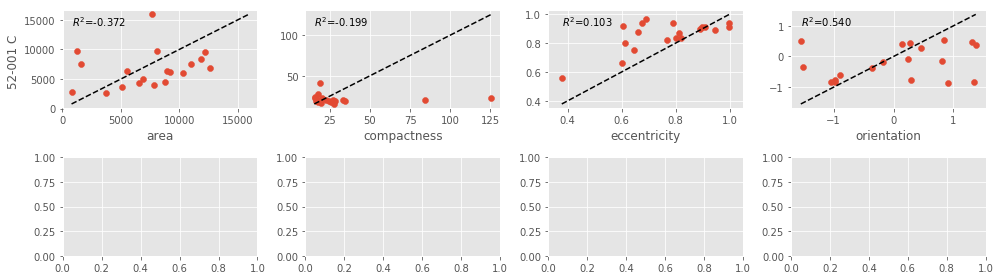

In [19]:
fig, axes = plt.subplots(ncols=len(columns), nrows=np.maximum(2, len(plot_files)), 
                         figsize=(14, 2 * np.maximum(2, len(plot_files))))
for (_, row), axrow in zip(plot_files.iterrows(), axes):
    if row['model'] != 'C':
        continue
    y, y_pred, _, _ = pickle.load(open(os.path.join(*row[['filepath', 'filename']]), 'rb'))
    if isinstance(y, list):
        y = pd.concat(y)
        y_pred = pd.concat(y_pred)
    idx = y['electrode'] == 'D017'
#     idx = np.logical_or(idx, y['electrode'] == 'B03')
#     idx = np.logical_or(idx, y['electrode'] == 'C08')
#     idx = np.logical_or(idx, y['electrode'] == 'E09')
    y = y[np.logical_not(idx)]
    y_pred = y_pred[np.logical_not(idx)]
    row['r2_area'] = sklm.r2_score(y['area'], np.nan_to_num(y_pred['area']))
    row['r2_compactness'] = sklm.r2_score(y['compactness'], np.nan_to_num(y_pred['compactness']))
    row['r2_eccentricity'] = sklm.r2_score(y['eccentricity'], np.nan_to_num(y_pred['eccentricity']))
    err = np.abs(y['orientation'] - np.nan_to_num(y_pred['orientation']))
    err = np.where(err > np.pi / 2, np.pi - err, err)
    # Use circular variance in `ss_tot`, which divides by len(yt).
    # Therefore, we also need to divide `ss_res` by len(yt), which
    # is the same as taking the mean instead of the sum.
    ss_res = np.mean(err ** 2)
    # ss_tot = np.sum((yt - np.mean(yt)) ** 2)
    ss_tot = spst.circvar(y['orientation'], low=-np.pi / 2, high=np.pi / 2)
    row['r2_orientation'] = 1 - ss_res / (ss_tot + 1e-12)
                
    cond = y_pred['orientation'] > 0.7
#     print(y[cond], y_pred[cond])
    for col, ax in zip(columns, axrow):
        ax.scatter(y[col], y_pred[col])
        minval = np.minimum(y[col].min(), y_pred[col].min())
        maxval = np.maximum(y[col].max(), y_pred[col].max())
        ax.plot([minval, maxval], [minval, maxval], 'k--')
        ax.set_xlabel(col)
        ax.text(minval, maxval, "$R^2$=%.3f" % float(row['r2_' + col]), va='top')
    axrow[0].set_ylabel('%s %s %s' % (row['subject'], row['model'],
                                      "adjust" if row['adjust_bias'] else ""))
#     break
fig.tight_layout()

In [20]:
predcols = ['area', 'orientation', 'eccentricity', 'compactness']

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:964: RuntimeWarning: invalid value encountered in multiply
  scl = np.multiply(avg, 0) + scl
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2490: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


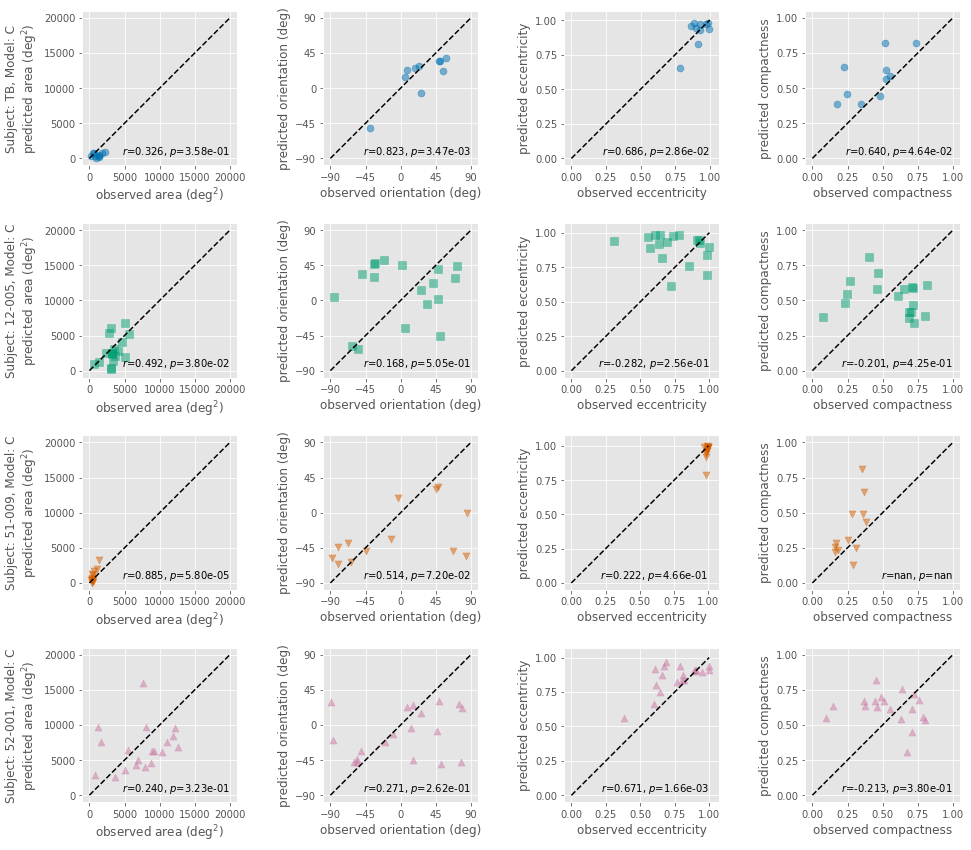

In [21]:
fig, axes = plt.subplots(ncols=len(predcols), nrows=len(subjects), 
                         figsize=(14, 3 * len(subjects)))
markers = ['o', 's', 'v', '^']
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']
ticks = [[0, 20000], [-90, 90], [0, 1], [0, 1]]
limits = [[-2000, 22000], [-108, 108], [-0.1, 1.1], [-0.1, 1.1]]
labels = ['area (deg$^2$)', 'orientation (deg)', 'eccentricity', 'compactness']
for subject, marker, color, axrow in zip(subjects, markers, colors, axes):
    for _, row in best[np.logical_and(best['subject'] == subject, best['model'] == 'C')].iterrows():
        for col, ax, tick, lim, label in zip(predcols, axrow, ticks, limits, labels):
            y = row['y_test']
            y_pred = row['y_pred']
            ax.scatter(y[col], y_pred[col], marker=marker, s=50, c=color, alpha=0.5)
            ax.plot([tick[0], tick[1]], [tick[0], tick[1]], 'k--')
            ax.set_xlim(*lim)
            ax.set_ylim(*lim)
            ax.set_xticks(np.linspace(*tick, num=5))
            ax.set_yticks(np.linspace(*tick, num=5))
            ax.set_xlabel('observed %s' % label)
            ax.set_ylabel('predicted %s' % label)
            ax.axis('square')
            slope, intercept, rval, pval, _ = spst.linregress(y[col], y_pred[col])
            ax.text(tick[1], tick[0], "$r$=%.3f, $p$=%.2e" % (rval, pval), va='bottom', ha='right')
    axrow[0].set_ylabel('Subject: %s, Model: %s\npredicted %s' % (row['subject'], row['model'], labels[0]))
fig.tight_layout()
fig.savefig('predict-cv-C.png')

In [22]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [23]:
y, y_pred, _, _ = pickle.load(open(os.path.join(*row[['filepath', 'filename']]), 'rb'))

In [24]:
for col in columns:
    df = pd.DataFrame({'y': y[col], 'y_hat': y_pred[col]})
    model = ols('y ~ y_hat', data=df).fit()
    anovaResults = anova_lm(model)
    print('')
    print(col)
    print(anovaResults)


area
            df        sum_sq       mean_sq         F    PR(>F)
y_hat      1.0  1.362703e+07  1.362703e+07  1.037279  0.322732
Residual  17.0  2.233338e+08  1.313728e+07       NaN       NaN

compactness
            df        sum_sq     mean_sq         F   PR(>F)
y_hat      1.0     28.184564   28.184564  0.035423  0.85294
Residual  17.0  13526.093664  795.652568       NaN      NaN

eccentricity
            df    sum_sq   mean_sq          F    PR(>F)
y_hat      1.0  0.209524  0.209524  13.927614  0.001659
Residual  17.0  0.255744  0.015044        NaN       NaN

orientation
            df     sum_sq   mean_sq         F    PR(>F)
y_hat      1.0   1.220794  1.220794  1.345522  0.262095
Residual  17.0  15.424135  0.907302       NaN       NaN


/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
